# Image API

Trying out to see what it would take to build an API that centers around interactive exploration of individual images - potentially leading up to a batch processing workflow.

In [234]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image


class StreetViewImage:
    def __init__(self, path: Path):
        self.path = path
        self.image = Image.open(self.path)
        self.image_array = np.asarray(self.image)

    def id(self):
        return self.path.stem
    
    def mask_path(self):
        # TODO: perhaps add the model that was used as subdir?
        return self.path.with_suffix('npz')

    def segment(self):
        ...

    def plot(self):
        plt.figure()
        plt.imshow(self.image)

    @property
    def segmentation(self):
        return Segmentation.from_saved(self.path)
    
    def get_instances(self, label: str):
        mask = self.segmentation.get_instances(label=label)
        # TODO: return as Instance object, but currently that doesn't support RGB(A) images
        return np.ma.masked_array(self.image_array, mask=mask)

    def plot_instances(self, label: str):
        mask = self.segmentation.get_instances(label=label)
        
        rgba_image = np.array(self.image.convert("RGBA"))
        rgba_image[..., 3] = np.where(mask.mask.mask, 0, 255)
        plt.imshow(rgba_image[..., :])
        

class Segmentation():

    def __init__(self, mask: np.ndarray, labels: dict[int, str] = {}):
        self.mask = mask
        self.labels = labels
        
    @classmethod
    def from_saved(cls, image_path: Path):
        """Load mask and labels from previously saved segmentation."""
        mask_file = image_path.with_suffix('.npz')    
        label_file = (image_path.parent.parent / "data" / "parquet" / image_path.name).with_suffix('.stat.parquet')

        try:
            mask = np.load(mask_file, allow_pickle=False)["arr_0"]
        except FileNotFoundError as exc:
            raise FileNotFoundError("Mask file not found. Have you segmented the image?") from exc
            
        try:
            stats = pd.read_parquet(label_file).loc[0]
            labels = dict(zip(stats.instance.tolist(), stats.label))
        except FileNotFoundError as exc:
            raise FileNotFoundError("Label file not found. Have you segmented the image with stats calculation?") from exc
        
        return cls(mask, labels)
    
    def plot(self):
        """Plot the segmentation mask."""
        plt.figure()
        plt.imshow(self.mask)

    def __repr__(self):
        return f"Segmentation(mask={self.mask}, labels={self.labels})"

    def get_instances(self, label: str):
        """Return an array of instances corresponding to label."""
        index = [k for (k, v) in self.labels.items() if v==label][0]
        instance_mask = np.ma.masked_where(self.mask != index, self.mask)
        return Instance(instance_mask)
    

class Instance:
    def __init__(self, mask: np.ma.MaskedArray):
        self.mask = mask

    def __repr__(self):
        return f"Instance(mask={self.mask})"
    
    def plot(self):
        plt.figure()
        plt.imshow(self.mask)


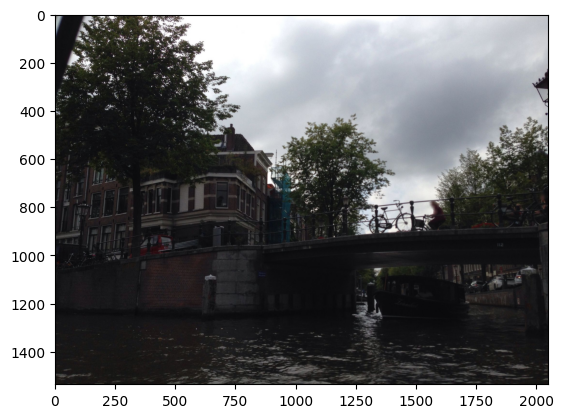

In [235]:
# Load a sample image that has already been segmented
import streetscapes

streetscapes.conf.PARQUET_DIR / "147302574068438.parquet"
sample_image = streetscapes.conf.IMAGE_DIR / "147302574068438.jpeg"
image = StreetViewImage(sample_image)
image.plot()

In [236]:
# Access the segmentation mask directly
image.segmentation

Segmentation(mask=[[ 7  7  7 ...  6  6  6]
 [ 7  7  7 ...  6  6  6]
 [ 7  7  7 ...  6  6  6]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]], labels={1: 'building', 2: 'fence', 3: 'boat', 4: 'boat', 5: 'pole', 6: 'sky', 7: 'pole', 8: 'wall', 9: 'street-light', 10: 'water', 11: 'vegetation', 12: 'person'})

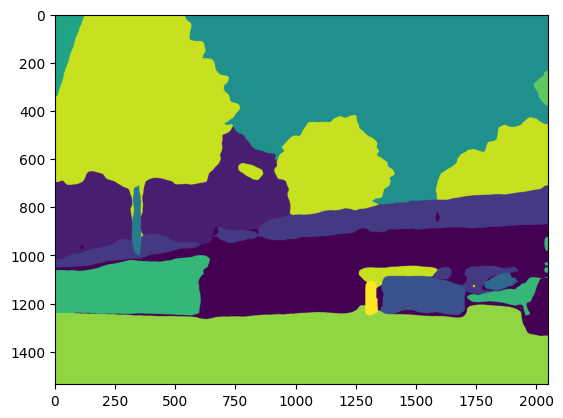

In [237]:
# Visualize the segmentation mask (unpolished)
image.segmentation.plot()

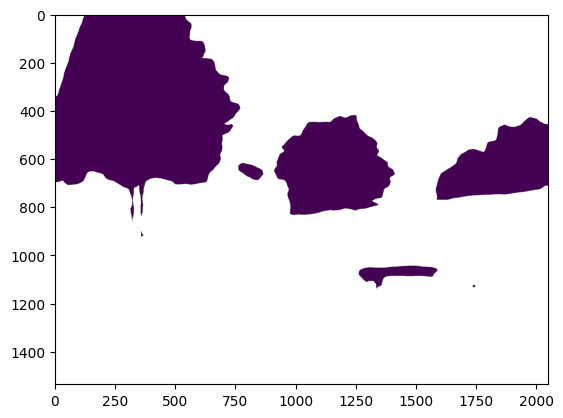

In [238]:
# Extract individual instances from the segmentation mask
image.segmentation.get_instances(label='vegetation').plot()

In [242]:
# TODO: get_instances should return iterable of Instance objects that support RGBA figures, have a plot method, and I want to be able to calculate statistics on them.

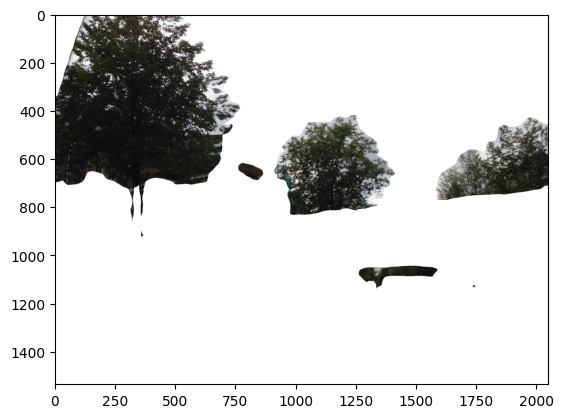

In [240]:
# Inspect the original image but only the instances of interest
image.plot_instances(label='vegetation')

In [241]:
image.get_instances(label='vegetation')

masked_array(
  data=[[[--, --, --],
         [--, --, --],
         [--, --, --],
         ...,
         [--, --, --],
         [--, --, --],
         [--, --, --]],

        [[--, --, --],
         [--, --, --],
         [--, --, --],
         ...,
         [--, --, --],
         [--, --, --],
         [--, --, --]],

        [[--, --, --],
         [--, --, --],
         [--, --, --],
         ...,
         [--, --, --],
         [--, --, --],
         [--, --, --]],

        ...,

        [[--, --, --],
         [--, --, --],
         [--, --, --],
         ...,
         [--, --, --],
         [--, --, --],
         [--, --, --]],

        [[--, --, --],
         [--, --, --],
         [--, --, --],
         ...,
         [--, --, --],
         [--, --, --],
         [--, --, --]],

        [[--, --, --],
         [--, --, --],
         [--, --, --],
         ...,
         [--, --, --],
         [--, --, --],
         [--, --, --]]],
  mask=[[[ True,  True,  True],
         [ True,